In [1]:
# STEP 1: IMPORT LIBRARIES

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
from lime.lime_tabular import LimeTabularExplainer
from anchor import anchor_tabular
import openai
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
df['target'].value_counts()

target
1    629
0    561
Name: count, dtype: int64

In [5]:
X = df.drop("target", axis=1)
y = df["target"]

In [7]:
# Scale numerical features for LIME/Anchors stability
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from xgboost import XGBClassifier

num_classes = y.nunique()

model = XGBClassifier(
    objective="binary:logistic",
    num_class=num_classes if num_classes > 2 else None,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss" if num_classes == 2 else "mlogloss",
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9201680672268907
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       112
           1       0.91      0.94      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238



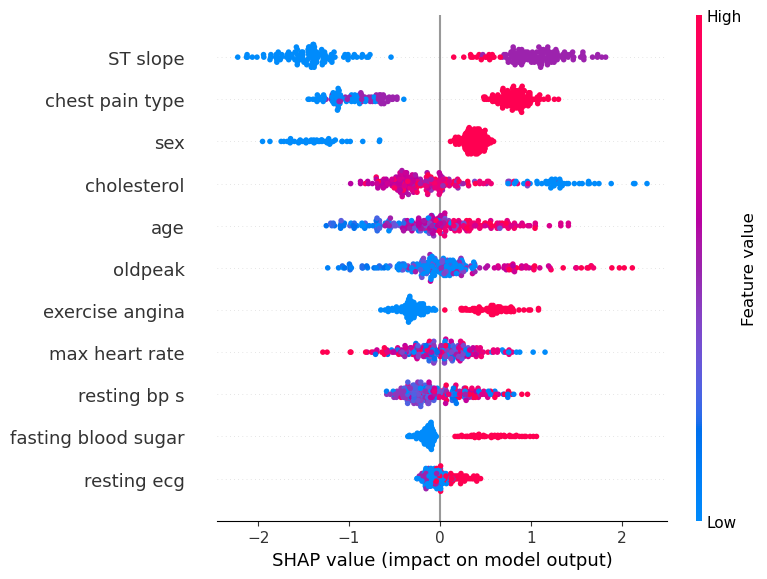

In [11]:
# Explain predictions of the model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


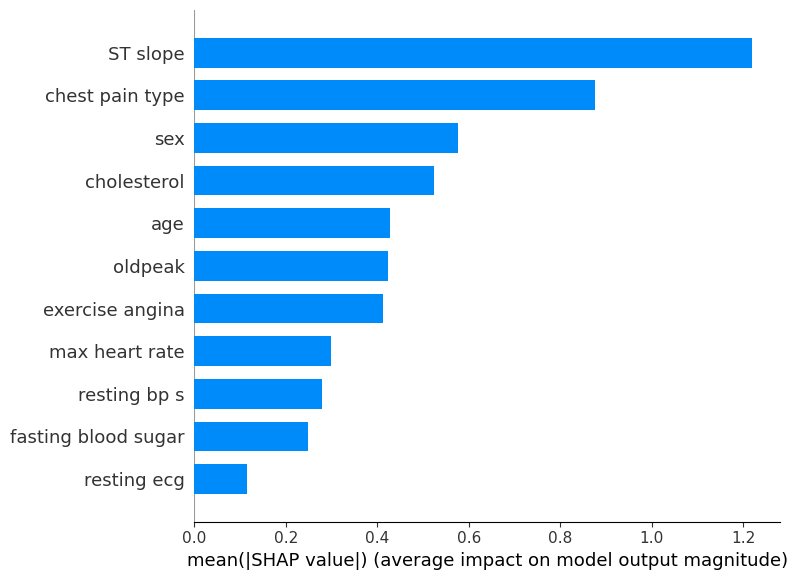

In [13]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [15]:
# Patient index
i = 60
patient = X_test.iloc[i]
patient_data = X.iloc[X_test.index[i]]
print(patient_data)

age                     56.0
sex                      1.0
chest pain type          4.0
resting bp s           130.0
cholesterol            283.0
fasting blood sugar      1.0
resting ecg              2.0
max heart rate         103.0
exercise angina          1.0
oldpeak                  1.6
ST slope                 3.0
Name: 1123, dtype: float64


In [17]:
# Enable JS for interactive plots
shap.initjs()

# Force plot for one patient
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    patient
)

In [19]:
# TABLE VERSION OF SHAP VALUES
shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "SHAP_value": shap_values[i]     # ✅ FIXED
}).sort_values("SHAP_value", ascending=False)

print(shap_df.to_string(index=False))

            Feature  SHAP_value
    chest pain type    0.905084
    exercise angina    0.777402
        cholesterol    0.769678
           ST slope    0.580189
fasting blood sugar    0.469421
            oldpeak    0.436909
     max heart rate    0.266055
                sex    0.264256
        resting ecg    0.123322
                age   -0.017065
       resting bp s   -0.253094


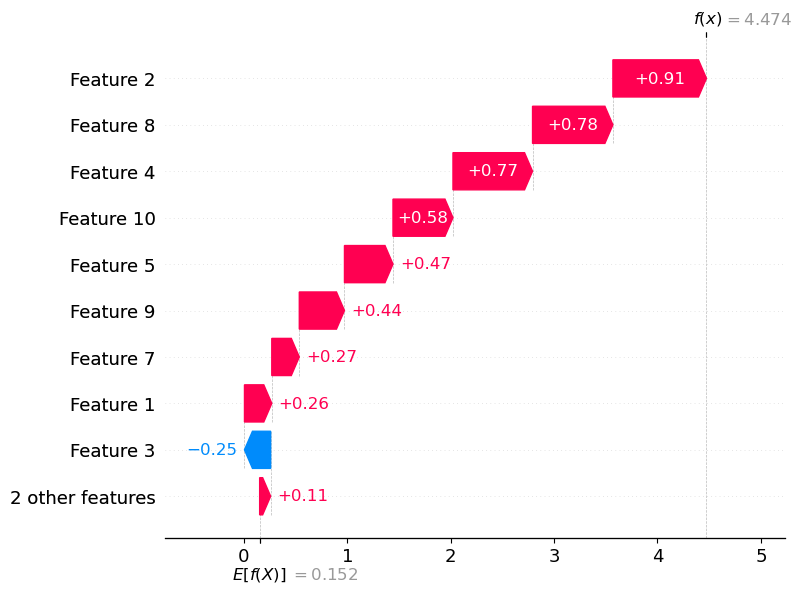

In [21]:
# Waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[i]
)

In [23]:
# Display features
print("Explaining patient", i)
print(patient)
print("\nOriginal (unscaled) data:\n", X.iloc[X_test.index[i]])
print("True label:", y_test.iloc[i])

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

exp_lime = explainer_lime.explain_instance(
    data_row=patient.values,
    predict_fn=model.predict_proba,
    num_features=10
)

print(exp_lime.as_list())

Explaining patient 60
age                    0.243721
sex                    0.555995
chest pain type        0.820487
resting bp s          -0.117301
cholesterol            0.716489
fasting blood sugar    1.919646
resting ecg            1.496197
max heart rate        -1.440111
exercise angina        1.257515
oldpeak                0.623666
ST slope               2.254383
Name: 1123, dtype: float64

Original (unscaled) data:
 age                     56.0
sex                      1.0
chest pain type          4.0
resting bp s           130.0
cholesterol            283.0
fasting blood sugar      1.0
resting ecg              2.0
max heart rate         103.0
exercise angina          1.0
oldpeak                  1.6
ST slope                 3.0
Name: 1123, dtype: float64
True label: 1
[('-0.25 < chest pain type <= 0.82', 0.24068958457837678), ('-0.80 < exercise angina <= 1.26', 0.13304838885501138), ('ST slope > 0.62', 0.08366212489774785), ('fasting blood sugar > -0.52', 0.08063394894784945)

In [25]:
exp_lime.show_in_notebook(show_table=True)
lime_text = str(exp_lime.as_list())

In [27]:
from alibi.explainers import AnchorTabular

# Anchor expects predict() to take a numpy array, not a DataFrame.
predict_fn = lambda x: model.predict(x)

# Anchor Explainer
explainer_anchor = AnchorTabular(
    predictor=predict_fn,
    feature_names=X_train.columns.tolist()
)

# Fit discretizer thresholds
explainer_anchor.fit(
    X_train.values,      
    disc_perc=[25, 50, 75]
)


patient = X_test.iloc[i].values.reshape(1, -1)  


# Anchor Explanation
anchor_exp = explainer_anchor.explain(
    patient,
    threshold=0.95      # anchor rule must be ≥ 95% precision
)


# Display Explanation


print(f"ANCHOR RULE FOR PATIENT {i}")
print("\nAnchor Rule:")
print(anchor_exp.anchor)

print("\nPrecision:", anchor_exp.precision)
print("Coverage:", anchor_exp.coverage)

#print("\nExplanation Details:")
#print(anchor_exp.raw)



ANCHOR RULE FOR PATIENT 60

Anchor Rule:
['ST slope > -1.02', 'chest pain type > -0.25', 'fasting blood sugar > -0.52']

Precision: 1.0
Coverage: 0.1001


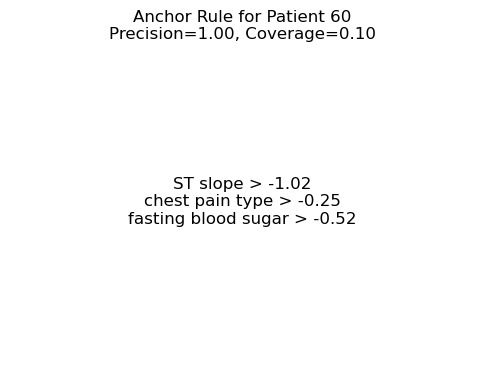

In [28]:
rule_text = "\n".join(anchor_exp.anchor)

plt.figure(figsize=(6,4))
plt.text(0.5, 0.5, rule_text, fontsize=12, ha='center', va='center')
plt.title(f"Anchor Rule for Patient {i}\nPrecision={anchor_exp.precision:.2f}, Coverage={anchor_exp.coverage:.2f}")
plt.axis('off')
plt.show()

Accuracy: 0.9201680672268907


Text(0.5, 1.0, 'Confusion Matrix')

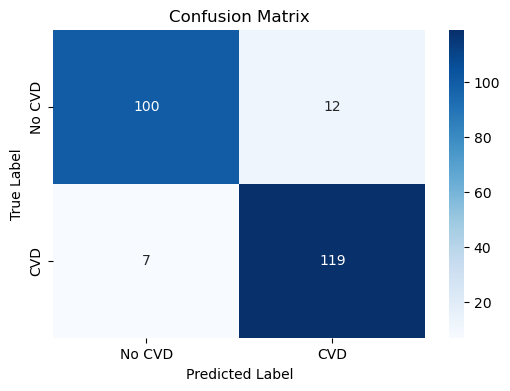

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Create figure
plt.figure(figsize=(6, 4))

# Heatmap with class labels
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No CVD", "CVD"],
    yticklabels=["No CVD", "CVD"],
    cbar=True
)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Area Under the Curve (AUC): 0.964


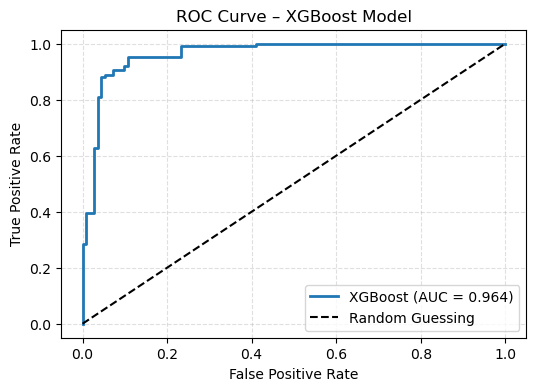

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(y_test, y_prob)

# Create figure
plt.figure(figsize=(6, 4))

# style ROC curve
plt.step(
    fpr,
    tpr,
    where="post",
    linewidth=2,
    label=f"XGBoost (AUC = {roc_auc:.3f})"
)

# Diagonal baseline
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="black",
    label="Random Guessing"
)

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost Model")

# Grid
plt.grid(True, linestyle="--", alpha=0.4)

# Legend
plt.legend(loc="lower right")


print(f"Area Under the Curve (AUC): {auc_score:.3f}")
